In [122]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable, FreeParameter
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.quantum_information.pauli_string import PauliString

from qiskit_braket_provider import BraketLocalBackend

from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit.providers.basicaer import QasmSimulatorPy  # just a stand-in for a real backend
from qiskit import QuantumCircuit, Aer, transpile

In [123]:
# set up device
device = LocalSimulator('braket_sv')

Inspect all available gates

In [124]:
gate_set = [attr for attr in dir(Gate) if attr[0].isupper()]
print(gate_set)

['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'GPi', 'GPi2', 'H', 'I', 'ISwap', 'MS', 'PSwap', 'PhaseShift', 'PulseGate', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


In [125]:
for iter in device.properties.action['braket.ir.jaqcd.program'].supportedResultTypes:
    print(iter)

name='Sample' observables=['x', 'y', 'z', 'h', 'i', 'hermitian'] minShots=1 maxShots=9223372036854775807
name='Expectation' observables=['x', 'y', 'z', 'h', 'i', 'hermitian'] minShots=0 maxShots=9223372036854775807
name='Variance' observables=['x', 'y', 'z', 'h', 'i', 'hermitian'] minShots=0 maxShots=9223372036854775807
name='Probability' observables=None minShots=0 maxShots=9223372036854775807
name='StateVector' observables=None minShots=0 maxShots=0
name='DensityMatrix' observables=None minShots=0 maxShots=0
name='Amplitude' observables=None minShots=0 maxShots=0


In [126]:
# For now, only stick to one-qubit gates
list_operators = ['CNot', 'H', 'I', 'Rx', 'Ry', 'Rz', 'X', 'Y', 'Z']

In [127]:
def get_random_circuit(n_qubits, operators):
    """
    Generate a random quantum circuit for a given number of qubits and a list of operators.
    """
    
    qc = Circuit()

    for q in range(n_qubits):
        gate = np.random.choice(operators)
            
        if gate == 'CNot':
            control_qubit = random.randint(0, n_qubits - 1)
            target_qubit = random.choice([i for i in range(n_qubits) if i != control_qubit])
            qc.cnot(control=control_qubit, target=target_qubit)
        elif gate == 'H':
            qc.h(q)
        elif gate == 'I':
            qc.i(q)
        elif gate == 'X':
            qc.x(q)
        elif gate == 'Y':
            qc.y(q)
        elif gate == 'Z':
            qc.z(q)    
        elif gate == 'Rx':
            angle = round(random.uniform(0, 2*np.pi), 2)
            qc.rx(q, angle)
        elif gate == 'Ry':
            angle = round(random.uniform(0, 2*np.pi), 2)
            qc.ry(q, angle)
        elif gate == 'Rz':
            angle = round(random.uniform(0, 2*np.pi), 2)
            qc.rz(q, angle)    

    return qc

In [128]:
n_qubits = 2

In [129]:
circ = get_random_circuit(n_qubits=n_qubits, operators=list_operators)
print(circ)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


In [130]:
circ.expectation(observable=Observable.X(), target=0)
exp_value = device.run(circ, shots=100).result().values[0]
print(exp_value)

-0.04


## Use Qiskit modules run on AWS LocalBackend

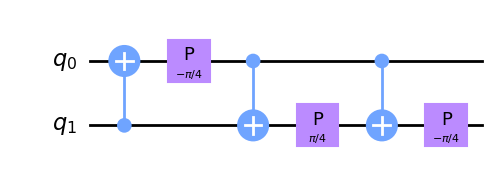

In [131]:
circuit = random_circuit(2, 2, seed=1).decompose(reps=1)
display(circuit.draw('mpl'))

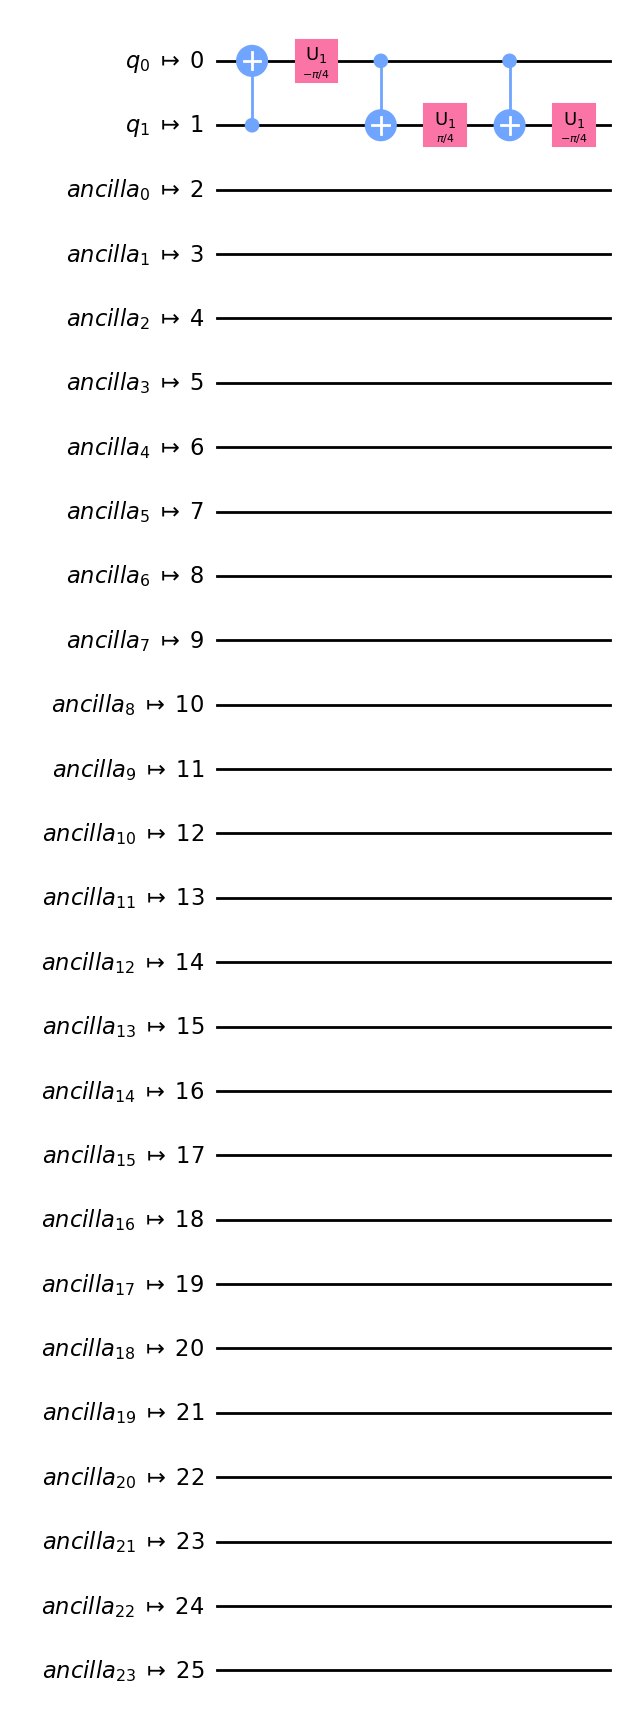

In [132]:
backend = BraketLocalBackend()
transpiled_circuit = transpile(circuit, backend=backend, optimization_level=1)
transpiled_circuit.draw('mpl')

In [133]:
estimator = Estimator()

In [134]:
observable = SparsePauliOp("IZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['IZ']


In [135]:
job = estimator.run(circuit, observable)
result = job.result()
print(f"  > Expectation value: {result.values[0]}")

  > Expectation value: 1.0


## AWS Free Parameter

In [136]:
#define a FreeParameter to represent the angle of a gate
theta = FreeParameter("theta")

#define a circuit with three qubits
my_circuit = Circuit().rx(0, theta)
print(my_circuit)

T  : |    0    |
                
q0 : -Rx(theta)-

T  : |    0    |

Unassigned parameters: [theta].


In [137]:
my_circuit.probability(target=0)

thetas = np.arange(0, 2 * np.pi, 0.05)
probs_one_state = [device.run(my_circuit(theta=theta), shots=0).result().values[0][1] for theta in thetas]

Text(0, 0.5, 'probability |1>')

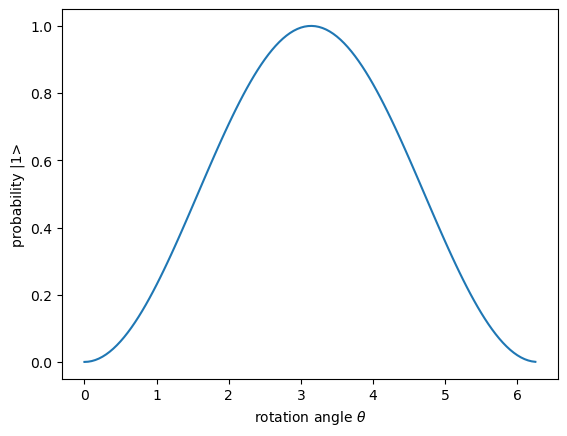

In [138]:
plt.plot(thetas, probs_one_state)
plt.xlabel(r'rotation angle $\theta$')
plt.ylabel(r'probability |1>')

## PennyLane

In [139]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

n_qubits = 1

print('Number of qubits: ', n_qubits)
device = qml.device('default.qubit', wires=n_qubits)

Number of qubits:  1


In [140]:
@qml.qnode(device)
def circuit(theta):
    qml.RX(theta, wires=0)
    return qml.probs(wires=0)

In [141]:
probs_one_state = np.array([circuit(theta)[1] for theta in thetas])

Text(0, 0.5, 'probability |1>')

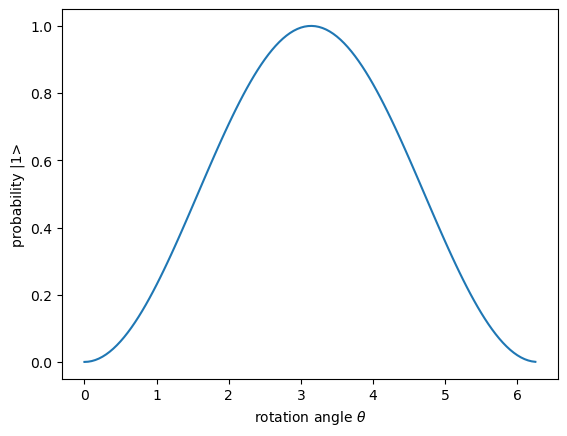

In [142]:
plt.plot(thetas, probs_one_state)
plt.xlabel(r'rotation angle $\theta$')
plt.ylabel(r'probability |1>')

In [143]:
print('Optimal rotation angle: ', np.round(thetas[np.argmax(probs_one_state)] / np.pi, 4), 'pi')

Optimal rotation angle:  1.0027 pi


## AWS Braket Expectation Value of Observable

In [144]:
# Run the circuit using LocalSimulator to get the state vector
device = LocalSimulator()

In [145]:
# Define a simple quantum circuit
circuit = Circuit()
circuit.h(0)
circuit.cnot(0, 1)
circuit.y(1)

print(circuit)

observable = Observable.Z() @ Observable.Z()
circuit.expectation(observable, target=[0, 1])
task = device.run(circuit, shots=1_000)  # shots=0 to get the state vector
result = task.result()
expectation_value = result.values[0]

print(f'\nExpectation value of {observable.ascii_symbols}: ', expectation_value)

T  : |0|1|2|
            
q0 : -H-C---
        |   
q1 : ---X-Y-

T  : |0|1|2|

Expectation value of ('Z@Z', 'Z@Z'):  -1.0


In [146]:
sigma_xz_twoq = Observable.X() @ Observable.Z()
sigma_xz_twoq_1 = Observable.TensorProduct([Observable.Z(), Observable.Z()])
if sigma_xz_twoq == sigma_xz_twoq_1:
    print('True')

print('Tensor Product Factors:', sigma_xz_twoq.factors)
print('Tensor Product ASCII representation:', sigma_xz_twoq.ascii_symbols)
print('Tensor Product Eigenvalues:', sigma_xz_twoq.eigenvalues)
print('Tensor Product Basis Rotation Gates:', sigma_xz_twoq.basis_rotation_gates)

Tensor Product Factors: (X('qubit_count': 1), Z('qubit_count': 1))
Tensor Product ASCII representation: ('X@Z', 'X@Z')
Tensor Product Eigenvalues: [ 1 -1 -1  1]
Tensor Product Basis Rotation Gates: (H('qubit_count': 1),)


#### Measure expectation values of Pauli observables

##### Braket

In [147]:
# Define a simple quantum circuit
circuit = Circuit()
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.x(0)

print(circuit)

T  : |0|1|
          
q0 : -H-X-
          
q1 : -H---
          
q2 : -H---

T  : |0|1|


In [148]:
# Create an operator out of a string of Pauli operators
pauli_string = PauliString('XYZ')
pauli_operator = pauli_string.to_unsigned_observable()

circuit.expectation(pauli_operator, target=[0, 1, 2])
# print(circuit)
task = device.run(circuit, shots=1_000)  
result = task.result()
expectation_value = result.values[0]

print(f'\nExpectation value of {pauli_operator.ascii_symbols}: ', expectation_value)


Expectation value of ('X@Y@Z', 'X@Y@Z', 'X@Y@Z'):  0.02


In [149]:
# Get a circuit that creates the eigenstate of the PauliString
print(pauli_string.eigenstate())
type(pauli_string.eigenstate())

T  : |0|1|
          
q0 : -H---
          
q1 : -H-S-

T  : |0|1|


braket.circuits.circuit.Circuit

##### Qiskit

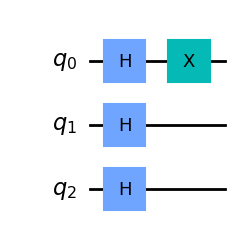

In [150]:
# Define a simple quantum circuit
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.x(0)

circuit.draw('mpl')

In [151]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

operator = SparsePauliOp(['XYZ'])
estimator = Estimator()

expectation_value = estimator.run(circuit, operator).result().values

# for shot-based simulation:
expectation_value = estimator.run(circuit, operator, shots=1_000).result().values
print("Expectation value: ", expectation_value)

Expectation value:  [-0.02904846]


#### Transpile Quantum Circuit with Qiskit Braket Provider

In [152]:
# Rigetti device
# device = AwsDevice('arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3')

In [153]:
backend = BraketLocalBackend()

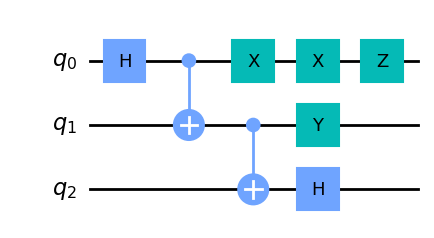

In [154]:
circ = QuantumCircuit(3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.h(2)
circ.y(1)
circ.x(0)
circ.x(0)
circ.z(0)
# circ.x(0)
# circ.sxdg(2)

circ.draw('mpl')

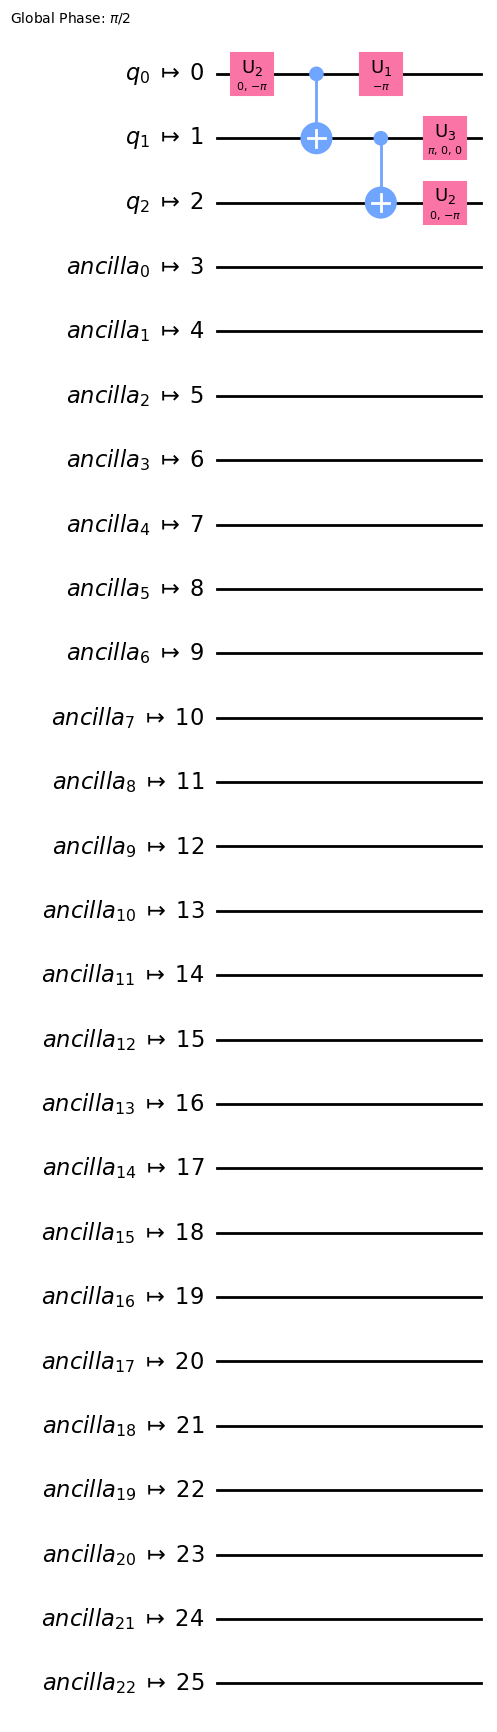

In [155]:
# backend = Aer.get_backend('qasm_simulator')
backend = BraketLocalBackend()
transpiled_circuit = transpile(circ, backend=backend, optimization_level=1, initial_layout=[0, 1, 2])
transpiled_circuit.draw('mpl')

The qiskit circuit gets transpiled by qiskit's native ``transpile`` function but takes an AWS Braket backend into account for the way how the circuit is transpiled. After transpilation, the circuit still is a qiskit ``QuantumCircuit`` object.

In [171]:
type(transpiled_circuit)

qiskit.circuit.quantumcircuit.QuantumCircuit

Use ``qbraid`` to transform a qiskit circuit to an AWS Braket circuit

In [178]:
from qbraid import circuit_wrapper

braket_circuit = circuit_wrapper(circ).transpile('braket')
print(braket_circuit)
print(type(braket_circuit))

T  : |0|1|2|3|4|
                
q0 : -H-C-X-X-Z-
        |       
q1 : ---X-C-Y---
          |     
q2 : -----X-H---

T  : |0|1|2|3|4|
<class 'braket.circuits.circuit.Circuit'>


#### Access the transpiled version of the circuit AFTER execution
(Source: https://docs.aws.amazon.com/braket/latest/developerguide/braket-compiled-circuits-inspecting.html)

When a circuit runs on a hardware device, it must be compiled in an acceptable format such as transpiling the circuit down to the native gates that are supported by the QPU. Inspecting the actual compiled output can be very useful for debugging purposes. You can view this circuit, which is stored in the object named ``compiledProgram``, for both Rigetti and OQC devices using the code below.

Today you cannot view your compiled circuit for IonQ devices.

In [169]:
task = AwsQuantumTask(arn=task_id, aws_session=session)
# after task finished
task_result = task.result()

# Returns the transpiled circuit that was run on the Rigetti device
compiledProgram = task_result.additional_metadata.rigettiMetadata.compiledProgram

NameError: name 'AwsQuantumTask' is not defined

## AWS Braket Pulse Control

In [ ]:
from braket.pulse import Frame

In [ ]:
"""device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
drive_frame = device.frames["q0_rf_frame"]"""